# Estudio: Métodos Tabulares

- Tomás Díaz Díaz
- Jose Antonio Sánchez Fernández

## Introducción

En este notebook se va a realizar el análisis y el estudio comparativo de los distintos métodos tabulares, que en nuestro caso son los siguientes:
- Monte Carlo (on-policy y off-policy)
- Diferencias temporales (SARSA, QLearning)
  
Para ello vamos a hacer uso del entorno de Gymnasium, que nos permite ensayar con distintos algoritmos de aprendizaje en diferentes escenarios, en nuestro caso hemos escogido el mapa llamado "Frozen Lake".


## Importaciones y configuración

A continuación vamos a importar las librerías necesarias para llevar a cabo el análisis y además vamos a establecer una serie de semillas para que las ejecuciones siempre tengan los mismos resultados.

In [1]:
!git clone https://github.com/oliatom350/rl_SFDD.git
# Instalar librerías
!pip install numpy matplotlib gym pandas torch

Cloning into 'rl_SFDD'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 100% (139/139), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 139 (delta 76), reused 90 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (139/139), 2.18 MiB | 7.48 MiB/s, done.
Resolving deltas: 100% (76/76), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━

In [2]:
import os
os.chdir('rl_SFDD')
print("Directorio actual:", os.getcwd())

Directorio actual: /content/rl_SFDD


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import sys
import gc
import torch

sys.path.append('src')
from AgentMonteCarloOnPolicy import AgentMonteCarloOnPolicy
from AgentMonteCarloOffPolicy import AgentMonteCarloOffPolicy
from AgentSARSA import AgentSARSA
from AgentQLearning import AgentQLearning

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

gc.collect()
torch.cuda.empty_cache()

# Fijamos la semilla para reproducibilidad
seed = 42
np.random.seed(seed)
np.random.default_rng(seed)
torch.manual_seed(seed)

# Fijamos la semilla en Gymnasium
def make_env(env_name, map_name):
    env = gym.make(env_name, map_name=map_name, is_slippery=False, render_mode='ansi')
    env.reset(seed=seed)
    env.action_space.seed(seed)
    env.observation_space.seed(seed)
    return env

Usando dispositivo: cpu


## Preparación del entorno

In [5]:
# En nuestro caso, el entorno es el de FrozenLake-v1
env_name = "FrozenLake-v1"
map_name = "4x4"
# Vamos a utilizar 5000 episodios para el entrenamiento
n_episodes = 5000
mc_on_policy_env = make_env(env_name, map_name)
mc_on_policy_env = gym.wrappers.RecordEpisodeStatistics(mc_on_policy_env, buffer_length=n_episodes)
mc_off_policy_env = make_env(env_name, map_name)
mc_off_policy_env = gym.wrappers.RecordEpisodeStatistics(mc_off_policy_env, buffer_length=n_episodes)
sarsa_env = make_env(env_name, map_name)
sarsa_env = gym.wrappers.RecordEpisodeStatistics(sarsa_env, buffer_length=n_episodes)
q_learning_env = make_env(env_name, map_name)
q_learning_env = gym.wrappers.RecordEpisodeStatistics(q_learning_env, buffer_length=n_episodes)

## Creación de agentes

A continuación vamos a dar una breve explicación de cada uno de los algoritmos utilizados en este estudio:

- Monte Carlo es una técnica de aprendizaje por refuerzo basada en la experiencia completa del episodio. En lugar de actualizar paso a paso, espera a que el episodio termine para calcular el retorno total desde cada estado-acción y usar ese valor para mejorar la estimación. Tenemos dos variantes:
  - On-Policy: aprende la política que sigue el agente (por ejemplo, ε-greedy). Utiliza exploración y actualiza Q en función de las acciones realmente tomadas.
  - Off-Policy: aprende sobre una política diferente a la que se sigue, utilizando técnicas como importancia relativa (importance sampling) para corregir el sesgo entre la política de comportamiento y la política objetivo.
- Diferencias Temporales: a diferencia de Monte Carlo, estos métodos actualizan los valores después de cada paso, basándose en una mezcla de experiencia real y estimaciones actuales. Tenemos también dos variantes:
  - SARSA: es un algoritmo on-policy, lo que significa que actualiza su política utilizando las acciones que realmente se toman, con exploración incluida (como ε-greedy).
  - Q-Learning: es un algoritmo off-policy. aprende el valor óptimo de las acciones asumiendo que siempre se tomará la mejor acción posible, sin importar la acción que el agente realmente ejecutó.

Ahora vamos a crear los cuatro agentes.

In [6]:
mc_on_policy_agent = AgentMonteCarloOnPolicy(mc_on_policy_env, num_episodes=5000, seed=seed)
mc_off_policy_agent = AgentMonteCarloOffPolicy(mc_off_policy_env, num_episodes=5000, seed=seed)
sarsa_agent = AgentSARSA(sarsa_env, num_episodes=5000, seed=seed)
q_learning_agent = AgentQLearning(q_learning_env, num_episodes=5000, seed=seed)

## Entrenamiento
En esta sección vamos a entrenar a los agentes, imprimiendo la política óptima.

In [7]:
mc_on_policy_agent.train()
print("\nOptimal policy:")
policy = mc_on_policy_agent.get_optimal_policy()
action_names = ['←', '↓', '→', '↑']
for s in range(mc_on_policy_env.observation_space.n):
    print(f"State {s}: {action_names[policy[s]]}")

mc_on_policy_agent.test()

Training: 100%|██████████| 5000/5000 [00:07<00:00, 711.73it/s]


Success rate: 2224/5000 (44.48%)

Optimal policy:
State 0: ↓
State 1: →
State 2: ↓
State 3: ←
State 4: ↓
State 5: ←
State 6: ↓
State 7: ←
State 8: →
State 9: ↓
State 10: ↓
State 11: ←
State 12: ←
State 13: →
State 14: →
State 15: ←
Test success rate: 100/100 (100.00%)


In [8]:
mc_off_policy_agent.train()
print("\nOptimal policy:")
policy = mc_off_policy_agent.get_optimal_policy()
action_names = ['←', '↓', '→', '↑']
for s in range(mc_off_policy_env.observation_space.n):
    print(f"State {s}: {action_names[policy[s]]}")

mc_off_policy_agent.test()

Training (Off-Policy): 100%|██████████| 5000/5000 [00:11<00:00, 437.47it/s] 


Optimal policy:
State 0: ↓
State 1: →
State 2: ↓
State 3: ←
State 4: ↓
State 5: ←
State 6: ↓
State 7: ←
State 8: →
State 9: →
State 10: ↓
State 11: ←
State 12: ←
State 13: →
State 14: →
State 15: ←
Test success rate: 100/100 (100.00%)


In [9]:
sarsa_agent.train()
print("\nOptimal policy:")
policy = sarsa_agent.get_optimal_policy()
action_names = ['←', '↓', '→', '↑']
for s in range(sarsa_env.observation_space.n):
    print(f"State {s}: {action_names[policy[s]]}")

sarsa_agent.test()

Training: 100%|██████████| 5000/5000 [00:01<00:00, 2504.45it/s]


Success rate: 2214/5000 (44.28%)

Optimal policy:
State 0: ↓
State 1: →
State 2: ↓
State 3: ←
State 4: ↓
State 5: ←
State 6: ↓
State 7: ←
State 8: →
State 9: ↓
State 10: ↓
State 11: ←
State 12: ←
State 13: →
State 14: →
State 15: ←
Test success rate: 100/100 (100.00%)


In [10]:
q_learning_agent.train()
print("\nOptimal policy:")
policy = q_learning_agent.get_optimal_policy()
action_names = ['←', '↓', '→', '↑']
for s in range(sarsa_env.observation_space.n):
    print(f"State {s}: {action_names[policy[s]]}")

q_learning_agent.test()

Training: 100%|██████████| 5000/5000 [00:01<00:00, 2674.29it/s]


Success rate: 2136/5000 (42.72%)

Optimal policy:
State 0: →
State 1: →
State 2: ↓
State 3: ←
State 4: ↓
State 5: ←
State 6: ↓
State 7: ←
State 8: →
State 9: →
State 10: ↓
State 11: ←
State 12: ←
State 13: →
State 14: →
State 15: ←
Test success rate: 100/100 (100.00%)


## Evaluación

A continuación vamos a definir las funciones para mostrar los gráficos de las recompensas por episodio y la duración de cada uno.

In [11]:
def get_moving_avgs(arr, window, convolution_mode):
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

def plot_episode_rewards(envs, rolling_length = 500):
    plt.figure(figsize=(30, 10))
    for name, env in envs:
        reward_moving_average = get_moving_avgs(
            env.return_queue,
            rolling_length,
            "valid"
        )
        plt.plot(range(len(reward_moving_average)), reward_moving_average, label=name)
    plt.xlabel("Episodio")
    plt.ylabel("Recompensa")
    plt.title("Evolución de la recompensa de los Episodios")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_episode_lengths(envs, rolling_length = 500):
    plt.figure(figsize=(30, 10))
    for name, env in envs:
        length_moving_average = get_moving_avgs(
            env.length_queue,
            rolling_length,
            "valid"
        )
        plt.plot(range(len(length_moving_average)), length_moving_average, label=name)
    plt.xlabel("Episodio")
    plt.ylabel("Duración")
    plt.title("Duración de los Episodios")
    plt.grid(True)
    plt.legend()
    plt.show()

Mostramos las recompensas de los episodios.

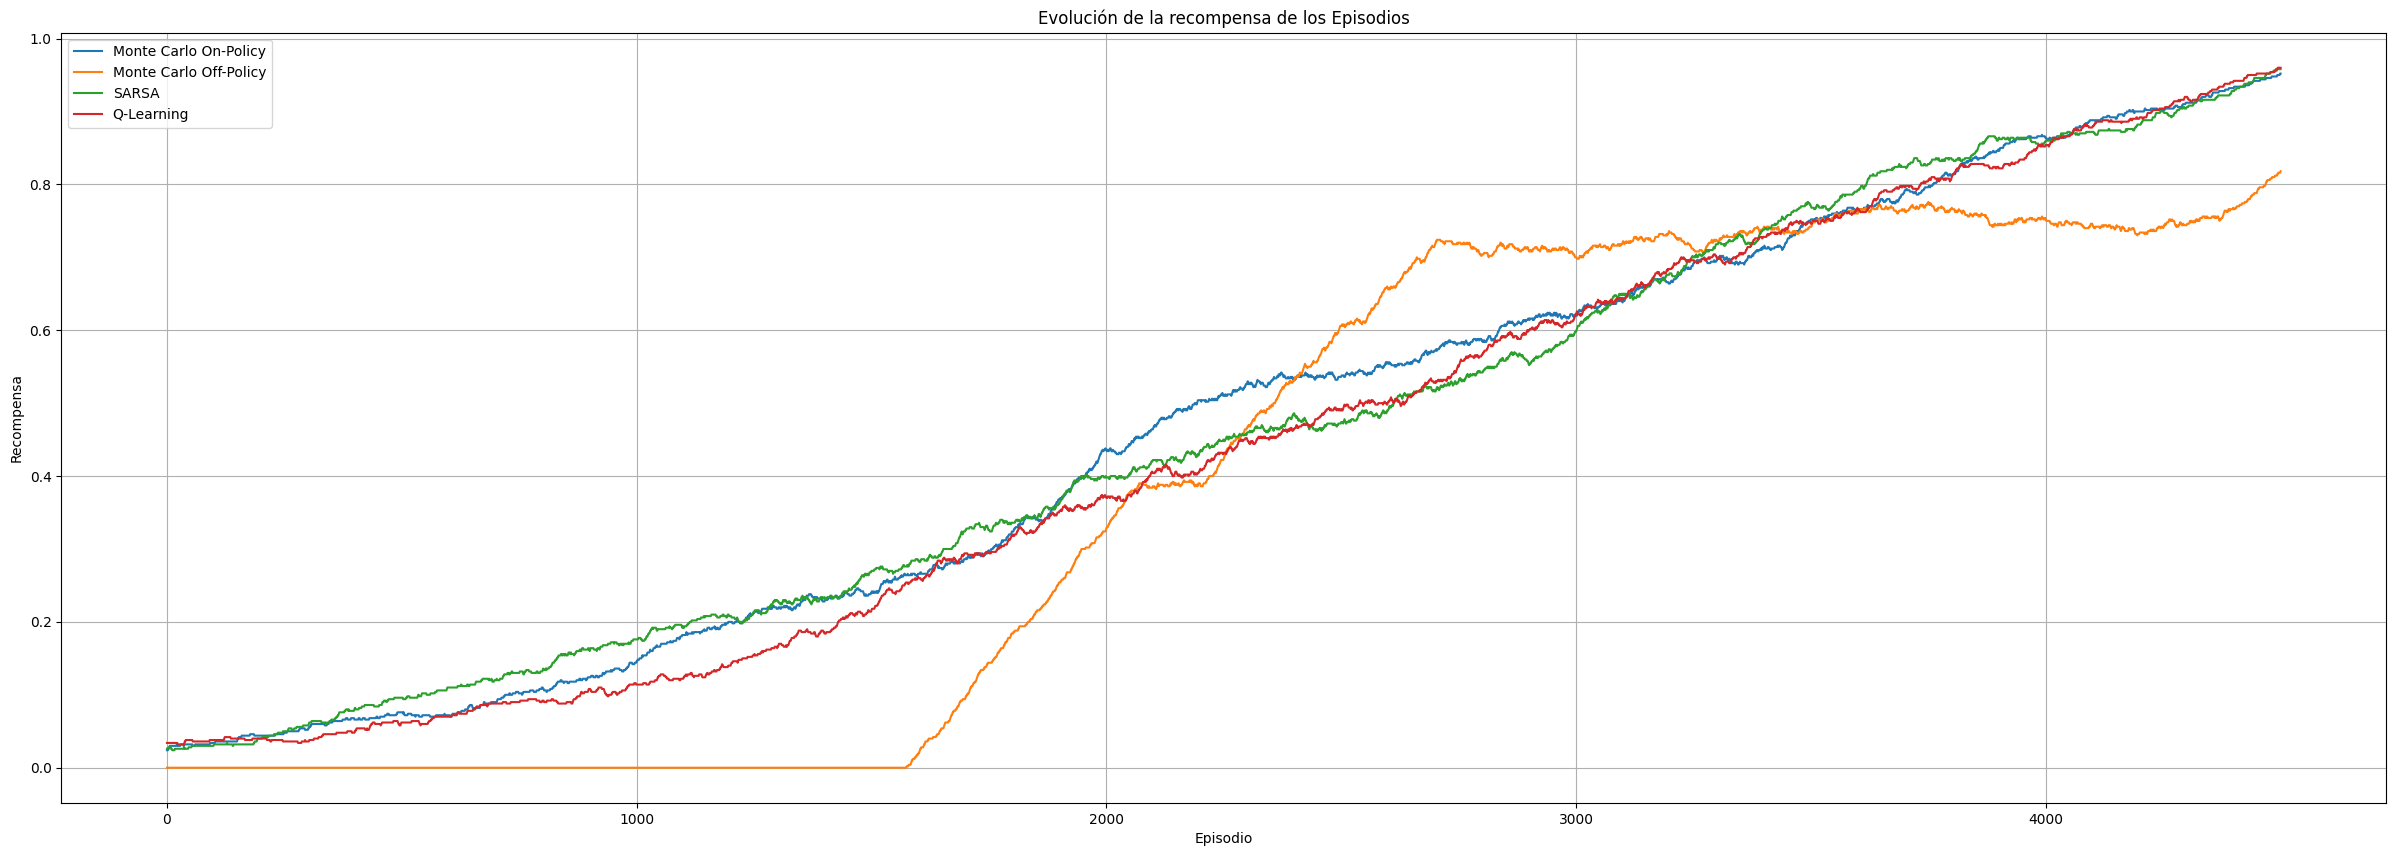

In [12]:
plot_episode_rewards([
    ("Monte Carlo On-Policy", mc_on_policy_env),
    ("Monte Carlo Off-Policy", mc_off_policy_env),
    ("SARSA", sarsa_env),
    ("Q-Learning", q_learning_env)
], rolling_length=500)

La gráfica representa la evolución de la recompensa media por episodio para los cuatro algoritmos de aprendizaje por refuerzo.

El algoritmo Monte Carlo On-Policy muestra una curva de aprendizaje bastante estable y progresiva. Aunque su progreso es más lento en las primeras fases del entrenamiento comparado con otros métodos, alcanza un buen desempeño hacia el final. Esto se debe a que Monte Carlo On-Policy actualiza los valores de acción solo después de haber terminado un episodio completo, lo cual aporta estabilidad pero hace que el aprendizaje sea menos reactivo a cambios inmediatos. En un entorno pequeño y determinista como FrozenLake sin efecto de resbalones, esta estabilidad es beneficiosa.

Por otro lado, Monte Carlo Off-Policy tiene una fase inicial en la que no parece aprender nada útil. Sin embargo, una vez que comienza a mejorar, lo hace de forma abrupta, aunque no alcanza la misma consistencia que los demás algoritmos. Este comportamiento puede explicarse porque el método depende de la corrección mediante pesos de importancia entre la política de comportamiento (la que ejecuta) y la política objetivo (la que evalúa). Si las trayectorias generadas no cubren adecuadamente los caminos óptimos debido a una política exploratoria poco efectiva al principio, el algoritmo no puede actualizar correctamente los valores. A partir del episodio 2500 empieza a ser mejor que los otro métodos, pero esta superioridad sólo dura hasta alrededor del episodio 3300, donde ya es inferior a los demás algoritmos.  

En el caso de SARSA, se observa un aprendizaje muy rápido al inicio, superando a otros métodos durante una gran parte del entrenamiento. Esto se debe a que SARSA aprende siguiendo la misma política que utiliza para explorar. Este enfoque tiende a ser más cauteloso y, en entornos con riesgos como caídas o trampas, esa cautela se traduce en una mejor capacidad de adaptación. En un mapa como FrozenLake 4x4 sin resbalones, SARSA puede explorar sin temor a aleatoriedades, lo que potencia su rendimiento.

Finalmente, Q-Learning muestra un comportamiento parecido al de SARSA, aunque con un enfoque más ambicioso. Al ser un algoritmo off-policy, Q-Learning actualiza su tabla Q pensando en la mejor acción posible, incluso si no la está siguiendo en ese momento. Esto lo hace más agresivo y, en entornos deterministas como este, esa ambición permite un aprendizaje eficiente y rápido. A largo plazo, su rendimiento converge con los demás algoritmos, mostrando su solidez en tareas simples.

En cuanto al entorno utilizado, FrozenLake 4x4 sin efecto de resbalones es un escenario muy adecuado para comparar algoritmos tabulares. Es pequeño, tiene una cantidad limitada de estados y transiciones deterministas, lo que facilita la convergencia. Sin embargo, esto también implica que las diferencias entre algoritmos tienden a ser menos notorias, ya que todos logran alcanzar un rendimiento óptimo con suficiente entrenamiento. En este contexto, las curvas similares que observas entre los métodos se deben a que el problema no es lo suficientemente complejo como para que se destaquen diferencias marcadas en eficiencia o estabilidad de aprendizaje.

Mostramos la duración de los episodios

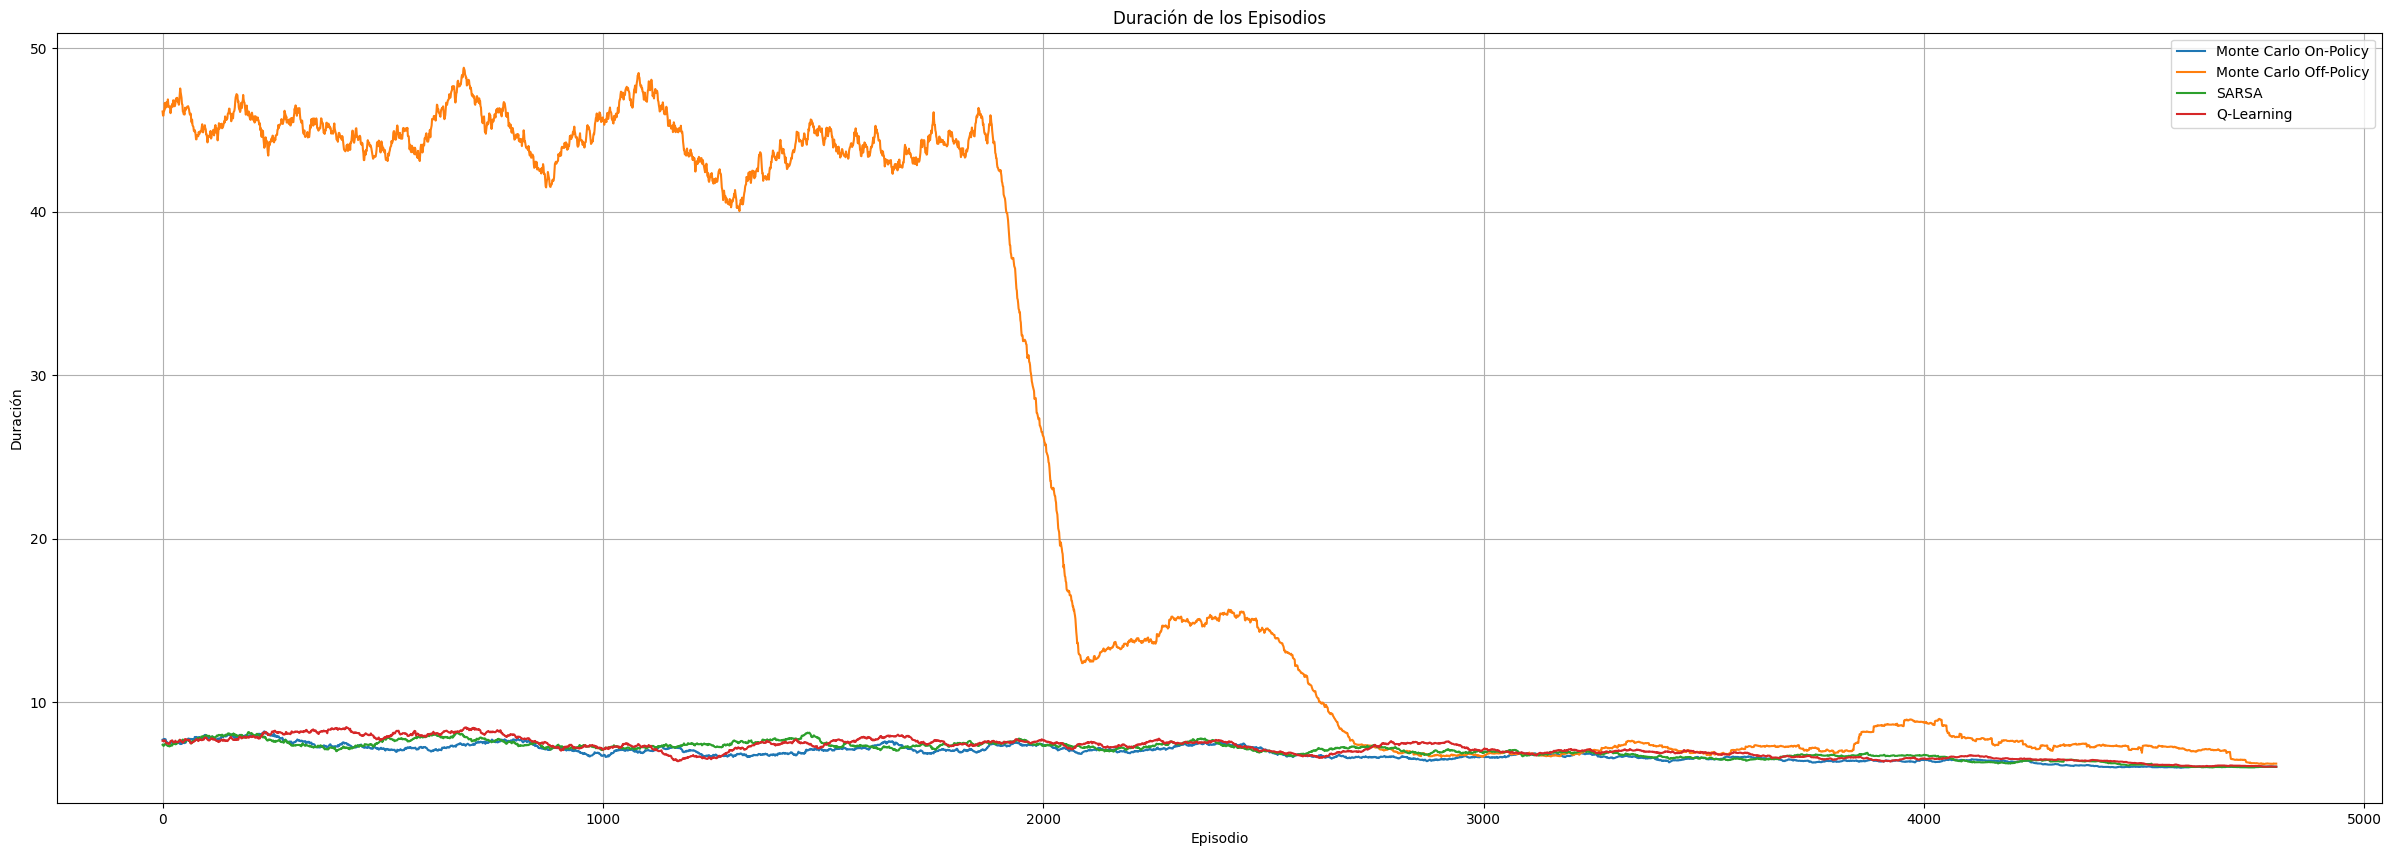

In [13]:
plot_episode_lengths([
    ("Monte Carlo On-Policy", mc_on_policy_env),
    ("Monte Carlo Off-Policy", mc_off_policy_env),
    ("SARSA", sarsa_env),
    ("Q-Learning", q_learning_env)
], rolling_length=200)

En esta gráfica se representa cómo evoluciona la duración promedio de los episodios a lo largo del entrenamiento.

Podemos observar que Monte Carlo off-Policy tiene una trayectoria muy peculiar. Durante aproximadamente los primeros 1800 episodios, sus episodios duran casi siempre el máximo de pasos permitido, lo que indica que el agente no está aprendiendo ninguna política efectiva para llegar al objetivo. Esto cuadra con lo visto en la gráfica de recompensas, donde también se mantenía en cero durante esa fase. Sin embargo, una vez que empieza a aprender, la duración de los episodios se reduce drásticamente, reflejando que el agente ha encontrado una ruta óptima o casi óptima para alcanzar el estado objetivo de forma eficiente. A pesar de su mal comienzo, el algoritmo consigue eventualmente rendimientos competitivos.

Por otro lado, los algoritmos Monte Carlo on-Policy, SARSA y Q-Learning muestran desde el inicio un comportamiento mucho más consistente, con duraciones de episodios más estables y relativamente bajas. Aunque hay pequeñas oscilaciones, en general se sitúan en torno a los 6-8 pasos, lo cual indica que el agente encuentra soluciones relativamente buenas desde etapas tempranas. La poca diferencia entre estas curvas sugiere que, en este entorno determinista y pequeño, todos estos algoritmos son suficientemente eficientes como para aprender estrategias útiles con rapidez.

La diferencia de comportamiento entre MC off-Policy y los demás se acentúa en entornos como FrozenLake 4x4, donde las rutas óptimas son cortas, pero si el agente no explora bien al principio o si la política de comportamiento es muy distinta de la política objetivo, puede tardar mucho más en descubrir caminos útiles. En cambio, los algoritmos on-policy (SARSA y Monte Carlo On-Policy) y Q-Learning, con su política de exploración más ajustada a la actualización, tienen más probabilidades de generar trayectorias que les permitan aprender desde el inicio.